In [344]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np

import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt

%matplotlib inline

from controllers import DeePC, DDeePC
plt.rcParams["figure.figsize"] = (15,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [345]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')

In [346]:
n = 3 # n = number of states
m = 3 # m = number of inputs
p = 3 # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    
noise_std = 1                

In [347]:
yd += np.random.rand(T,p)*noise_std
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([100,100,100]))
u_constraonts = np.kron(np.ones(Tf), np.array([100,100,100]))

## Imitation Learning

In [348]:
q = torch.ones(3)*200
r = torch.ones(3)*0.02
lam_y = torch.Tensor([0.1])

expert = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraonts,
    stochastic=True, linear=True, q=q, r=r, lam_y=lam_y
)

learner = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraonts,
    stochastic=True, linear=True, r=r
)

for param in learner.parameters():
    print(param)

Parameter containing:
tensor([9.9548, 8.9467, 9.5673], requires_grad=True)
Parameter containing:
tensor([10.4048], requires_grad=True)


### Before Training

[ 1.04561669 22.32709196 14.13460497  0.54757649 20.83385358 14.10943018
  0.91899199 21.64877446 13.83310727  0.36528682 23.08436422 13.26382289]
[ 1.54312236 22.44457048 13.97281285  1.09240867 20.06444518 17.23371326
  1.44326815 20.18097323 13.28359119  1.93487792 23.97914891 13.07343601]


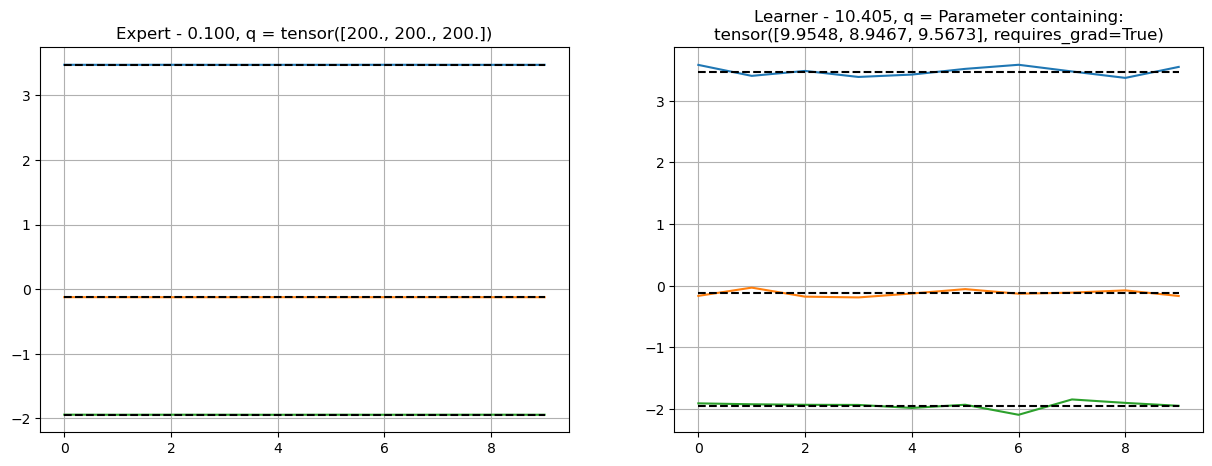

In [349]:
test_ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
test_ref = torch.kron(torch.ones(Tf), test_ref)
# ref_noise = ref + torch.Tensor(np.random.randn(30,)*noise_std)
index = int(np.random.uniform(low=0, high=50))
u_ini, y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
noise = np.random.randn(Tini*p,)*noise_std
print(y_ini)
y_ini += noise
print(y_ini)

_, y_pred , _ = learner(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))
_, y, _ = expert(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))

y_pred = y_pred.detach().numpy().reshape((Tf, 3))
y = y.detach().numpy().reshape((Tf, 3))
ref = test_ref.detach().numpy().reshape((Tf, 3))
plt.subplot(1,2,1)
plt.title(f'Expert - {expert.lam_y.item():.3f}, q = {expert.q}')
plt.grid('on')
plt.plot(range(Tf), y)
plt.plot(range(Tf), ref, 'k--')
plt.subplot(1,2,2)
plt.title(f'Learner - {learner.lam_y.item():.3f}, q = {learner.q}')
plt.grid('on')
plt.plot(range(Tf), y_pred)
plt.plot(range(Tf), ref, 'k--')
plt.show()

In [350]:
optim = torch.optim.Adagrad(learner.parameters(), lr=10)
pbar = tqdm(range(30000), ncols=150)
criterion = torch.nn.MSELoss()
# scheduler = lr_scheduler.LinearLR(optim, start_factor=1.0, end_factor=0.1, total_iters=100)

for i, count in enumerate(pbar):
    
    # Get random step response
    ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
    ref = torch.kron(torch.ones(Tf), ref)
    
    # Get random initial condition from data
    index = int(np.random.uniform(low=0, high=50))
    u_ini, y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
    y_ini += np.random.randn(Tini*p,)*noise_std

    # Get optimal action from controller, take MSE of predicted trajectory and reference signal
    u_pred, y_pred , cost = learner(ref=ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))
    # u, y, _ = expert(ref=ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))

    loss = criterion(input=y_pred, target=ref)
    optim.zero_grad()
    loss.backward()
    optim.step()

    # if count%100 == 0:     
    #     scheduler.step()
    
    pbar.set_description(f'Loss = {loss.item():.10f}, lam_y = {learner.lam_y.data.item():.9f}, q = {learner.q.data}')

Loss = 0.0000007414, lam_y = -0.234697878, q = tensor([20.1461, 20.0457, 20.1907]):   2%|▌                        | 603/30000 [00:32<26:39, 18.38it/s]


KeyboardInterrupt: 

## After Training

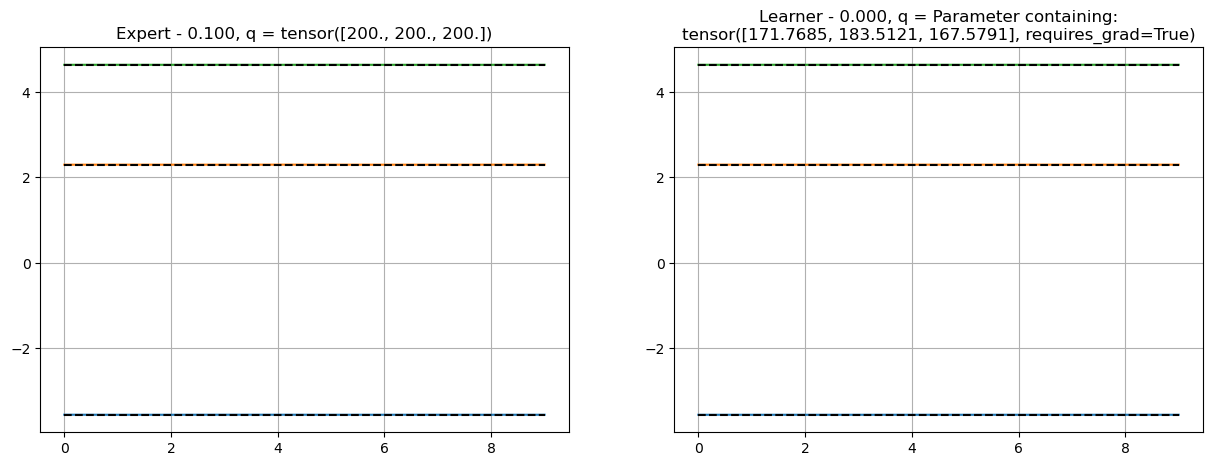

In [ ]:
test_ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
test_ref = torch.kron(torch.ones(Tf), test_ref)
# ref_noise = ref + torch.Tensor(np.random.randn(30,)*noise_std)
index = int(np.random.uniform(low=0, high=50))
u_ini, y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
noise = np.random.randn(Tini*p,)*noise_std
# print(y_ini)
y_ini += noise
# print(y_ini)

_, y_pred , _ = learner(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))
_, y, _ = expert(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))

y_pred = y_pred.detach().numpy().reshape((Tf, 3))
y = y.detach().numpy().reshape((Tf, 3))
ref = test_ref.detach().numpy().reshape((Tf, 3))
plt.subplot(1,2,1)
plt.title(f'Expert - {expert.lam_y.item():.3f}, q = {expert.q}')
plt.grid('on')
plt.plot(range(Tf), y)
plt.plot(range(Tf), ref, 'k--')
plt.subplot(1,2,2)
plt.title(f'Learner - {learner.lam_y.item():.3f}, q = {learner.q}')
plt.grid('on')
plt.plot(range(Tf), y_pred)
plt.plot(range(Tf), ref, 'k--')
plt.show()